[home](http://www.brandonrose.org)

# Document Clustering with Python

<img src='header_short.jpg'>

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the example. This guide covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

## Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

But first, I import everything I am going to need up front

In [2]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import pickle

In [3]:
save_clean_lines = open("clean_diabApp.pickle", "rb")
paras = pickle.load(save_clean_lines)
save_clean_lines.close()

paras

['blackberry url heremaybe url specific good luckpost work myglucohealth glucometer blackberry fda approved bluetooth meter take reading automatically phone web granted viewing right health care provider check level text recommendation feature opinion integrated notification offer test receive text message phone question step correct situation reply minute start send message worker working hour wife evening message support member prevented hospitalcheck url based company gen diabetic older thread wrote article precisely topic thing tech column url thought comment question management blackberry user',
 'putting blog friend recently diagnosed gadget smart phone plain dinky flip phone case emergency thing smart device apps smart device asks hoping favorite apps inspiration friend gee phone constantly thought thing carelink enlite data url people developing pwd basically care logbook wise printout pretty good love changed management huge fan android iphone tech savvy talking helpful wow ma


For the purposes of this walkthrough, imagine that I have 2 primary lists:
  - 'titles': the titles of the films in their rank order
  - 'synopses': the synopses of the films matched to the 'titles' order
  
  
In the full workbook that I posted to github you can walk through the import of these lists, but for brevity just keep in mind that for the rest of this walk-through I will focus on using these two lists. Of primary importance is the 'synopses' list; 'titles' is mostly used for labeling purposes.

# Stopwords, stemming, and tokenizing

In [4]:
# #import three lists: titles, links and wikipedia synopses
# titles = open('title_list.txt').read().split('\n')
# #ensures that only the first 100 are read in
# titles = titles[:100]

# links = open('link_list_imdb.txt').read().split('\n')
# links = links[:100]

# synopses_wiki = open('synopses_list_wiki.txt',encoding="utf8").read().split('\n BREAKS HERE')
# synopses_wiki = synopses_wiki[:100]

# synopses_clean_wiki = []
# for text in synopses_wiki:
#     text = BeautifulSoup(text, 'html.parser').getText()
#     #strips html formatting and converts to unicode
#     synopses_clean_wiki.append(text)

# synopses_wiki = synopses_clean_wiki
    
    
# genres = open('genres_list.txt').read().split('\n')
# genres = genres[:100]

# print(str(len(titles)) + ' titles')
# print(str(len(links)) + ' links')
# print(str(len(synopses_wiki)) + ' synopses')
# print(str(len(genres)) + ' genres')

In [5]:
# synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
# synopses_imdb = synopses_imdb[:100]

# synopses_clean_imdb = []

# for text in synopses_imdb:
#     text = BeautifulSoup(text, 'html.parser').getText()
#     #strips html formatting and converts to unicode
#     synopses_clean_imdb.append(text)

# synopses_imdb = synopses_clean_imdb

In [6]:
synopses = paras

# for i in range(len(synopses_wiki)):
#     item = synopses_wiki[i] + synopses_imdb[i]
#     synopses.append(item)
synopses

['blackberry url heremaybe url specific good luckpost work myglucohealth glucometer blackberry fda approved bluetooth meter take reading automatically phone web granted viewing right health care provider check level text recommendation feature opinion integrated notification offer test receive text message phone question step correct situation reply minute start send message worker working hour wife evening message support member prevented hospitalcheck url based company gen diabetic older thread wrote article precisely topic thing tech column url thought comment question management blackberry user',
 'putting blog friend recently diagnosed gadget smart phone plain dinky flip phone case emergency thing smart device apps smart device asks hoping favorite apps inspiration friend gee phone constantly thought thing carelink enlite data url people developing pwd basically care logbook wise printout pretty good love changed management huge fan android iphone tech savvy talking helpful wow ma

In [7]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
# ranks = []

# for i in range(0,len(titles)):
#     ranks.append(i+1)

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [8]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [9]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [10]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [11]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [12]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [13]:
vocab_frame.shape
vocab_frame.head(10)

,words
blackberri,blackberry
url,url
heremayb,heremaybe
url,url
specif,specific
good,good
luckpost,luckpost
work,work
myglucohealth,myglucohealth
glucomet,glucometer


## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=40, max_features=500,
                                 min_df=5, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
df.to_csv('Diabetes_TFIDF_Vect.csv')

Wall time: 304 ms
(45, 431)


terms is just a list of the features used in the tf-idf matrix. This is a vocabulary



In [15]:
terms = tfidf_vectorizer.get_feature_names()
terms

['ability',
 'access',
 'account',
 'active',
 'activity',
 'actual',
 'add',
 'added',
 'adding',
 'additional',
 'advice',
 'agree',
 'alert',
 'amazing',
 'android',
 'android iphone',
 'android phone',
 'announced',
 'answer',
 'apple',
 'application',
 'appreciated',
 'approved',
 'apps',
 'ate',
 'automatically',
 'awesome',
 'bad',
 'basal',
 'based',
 'basically',
 'benefit',
 'beta',
 'bgs',
 'big',
 'bit',
 'blackberry',
 'blog',
 'blood',
 'blood glucose',
 'blood sugar',
 'bluetooth',
 'board',
 'bolus',
 'bolus calculator',
 'box',
 'bring',
 'browser',
 'buddy',
 'built',
 'buy',
 'calculate',
 'calculation',
 'calculator',
 'called',
 'calorie',
 'capability',
 'carb',
 'carbohydrate',
 'carbs',
 'care',
 'carelink',
 'cgm',
 'challenge',
 'change',
 'chart',
 'check',
 'checked',
 'checking',
 'choice',
 'click',
 'code',
 'combination',
 'comment',
 'community',
 'company',
 'compatible',
 'complete',
 'computer',
 'connect',
 'contribute',
 'control',
 'cool',
 'corre

dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more synopses.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[ -6.66133815e-16,   7.67203699e-01,   1.00000000e+00, ...,
          8.87968368e-01,   8.10649274e-01,   9.01378366e-01],
       [  7.67203699e-01,  -2.22044605e-16,   7.51589734e-01, ...,
          6.69968556e-01,   5.97822509e-01,   6.89093609e-01],
       [  1.00000000e+00,   7.51589734e-01,   0.00000000e+00, ...,
          9.30689613e-01,   8.27813047e-01,   8.51895571e-01],
       ..., 
       [  8.87968368e-01,   6.69968556e-01,   9.30689613e-01, ...,
          3.33066907e-16,   4.59680808e-01,   5.96347080e-01],
       [  8.10649274e-01,   5.97822509e-01,   8.27813047e-01, ...,
          4.59680808e-01,   0.00000000e+00,   6.10301140e-01],
       [  9.01378366e-01,   6.89093609e-01,   8.51895571e-01, ...,
          5.96347080e-01,   6.10301140e-01,   6.66133815e-16]])

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [17]:
from sklearn.cluster import KMeans

num_clusters = 8
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
len(clusters)

Wall time: 146 ms


45

In [18]:
# from sklearn.externals import joblib

# #joblib.dump(km,  'doc_cluster.pkl')
# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

In [19]:
import pandas as pd

# films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

# frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
# frame.to_csv('films.csv')
indx=[i+1 for i in range(len(synopses))]
films = {  'Number': indx, 'Discussion': synopses, 'cluster': clusters }

frame = pd.DataFrame(films, index = [indx] , columns = ['Discussion', 'cluster'])
frame.to_csv('Discussion.csv')

In [20]:
frame['cluster'].value_counts()

1    16
0     8
4     6
3     4
2     4
7     3
6     2
5     2
Name: cluster, dtype: int64

In [21]:
# grouped = frame['rank'].groupby(frame['cluster'])
# grouped.mean()

In [23]:
# from __future__ import print_function


# from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
li=[]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :30]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        li.append(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])
    print('\n') #add whitespace
    print([i for i in li if i != li[2]]) #add whitespace
    
#     print("Cluster %d titles:" % i, end='')
#     for title in frame.ix[i]['title'].values.tolist():
#         print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    li=[]
    
print()
print()

Top terms per cluster:

Cluster 0 words: blood, sugar, nan, drop, insulin, factor, blood, user, url, time, sanofi, result, nan, nan, point, check, nan, knew, blood, nan, program, day, food, support, nan, target, nan, nan, data, goal,

[' blood', ' sugar', ' drop', ' insulin', ' factor', ' blood', ' user', ' url', ' time', ' sanofi', ' result', ' point', ' check', ' knew', ' blood', ' program', ' day', ' food', ' support', ' target', ' data', ' goal']


Cluster 1 words: phone, nan, food, insulin, log, mysugr, meter, nan, nan, enter, version, data, free, android, nan, thing, nan, url, work, nan, nan, note, track, nan, time, send, report, great, nan, nan,

[' phone', ' nan', ' insulin', ' log', ' mysugr', ' meter', ' nan', ' nan', ' enter', ' version', ' data', ' free', ' android', ' nan', ' thing', ' nan', ' url', ' work', ' nan', ' nan', ' note', ' track', ' nan', ' time', ' send', ' report', ' great', ' nan', ' nan']


Cluster 2 words: nan, nan, android, list, click, link, nan, nan, pe

In [24]:
# #This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
# frame['Rank'] = frame['rank'] 
# frame['Title'] = frame['title']

In [25]:
#export tables to HTML
# print(frame[['Rank', 'Title','cluster']].loc[frame['cluster'] == 3].to_html(index=False))

# Multidimensional scaling

Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use principal component analysis.

In [26]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()


In [27]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
# from nltk.tag import pos_tag

# def strip_proppers_POS(text):
#     tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
#     non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
#     return non_propernouns

## Visualizing document clusters


In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [36]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66affe',5: '#aaffaa', 6: '#7ff0b3', 7: '#eee98a'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3', 
                 3: 'Cluster 4',
                 4: 'Cluster 5', 
                 5: 'Cluster 6', 
                 6: 'Cluster 7', 
                 7: 'Cluster 8'}

Next, I plot the labeled observations (films, film titles) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

In [37]:
%matplotlib inline

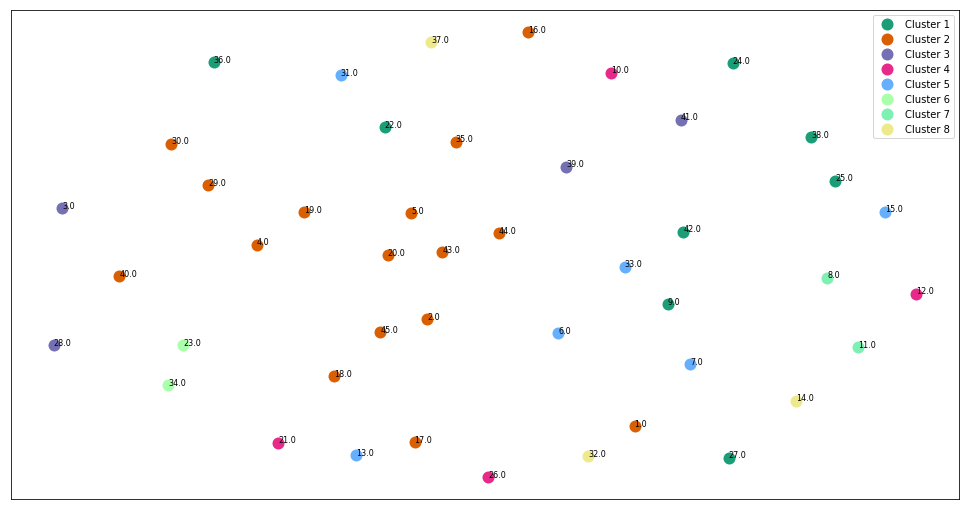

In [38]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=indx)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [39]:
plt.close()

The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with [D3.js](http://d3js.org/) I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon [mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [40]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

Here is the actual creation of the interactive scatterplot. I won't go into much more detail about it since it's pretty much a straightforward copy of one of the mpld3 examples, though I use a pandas groupby to group by cluster, then iterate through the groups as I layer the scatterplot. Note that relative to doing this with raw D3, mpld3 is much simpler to integrate into your Python workflow. If you click around the rest of my website you'll see that I do love D3, but for basic interactives I will probably use mpld3 a lot going forward.

Note that mpld3 lets you define some custom CSS, which I use to style the font, the axes, and the left margin on the figure.

In [41]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=indx)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

Now that I was successfuly able to cluster and plot the documents using k-means, I wanted to try another clustering algorithm. I chose the Ward clustering algorithm because it offers hierarchical clustering. Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. I used the precomputed cosine distance matrix (dist) to calclate a linkage_matrix, which I then plot as a dendrogram.

Note that this method returned 3 primary clusters, with the largest cluster being split into about 4 major subclusters. Note that the cluster in red contains many of the "Killed, soldiers, captain" films. Braveheart and Gladiator are within the same low-level cluster which is interesting as these are probably my two favorite movies.

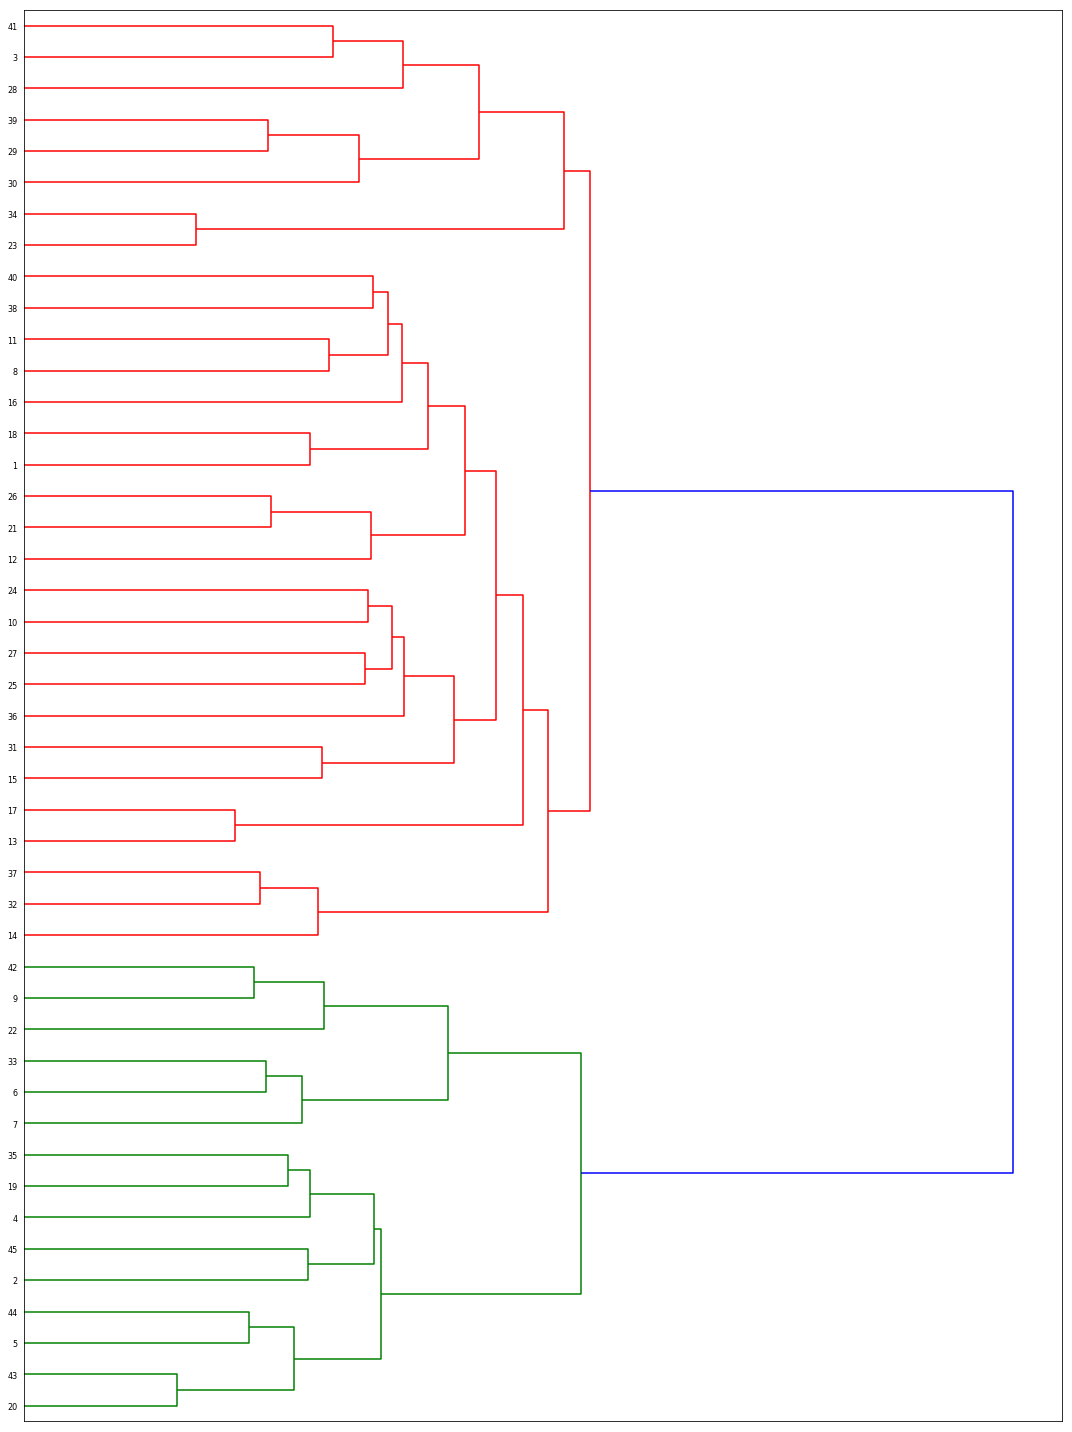

In [42]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=indx);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [120]:
plt.close()

# Latent Dirichlet Allocation


This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. There is quite a good high-level overview of probabilistic topic models by one of the big names in the field, David Blei, available in the Communications of the ACM here. Incidentally, Blei was one of the authors of the seminal paper on LDA.

For my implementaiton of LDA, I use the Gensim pacakage. I'm going to preprocess the synopses a bit differently here, and first I define a function to remove any proper noun.

In [44]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

Since the above function is just based on capitalization, it is prone to remove words at the beginning of sentences. So, I wrote the below function using NLTK's part of speech tagger. However, it took way too long to run across all synopses, so I stuck with the above.



In [45]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

Here I run the actual text processing (removing of proper nouns, tokenization, removal of stop words)

In [51]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

Wall time: 143 ms
Wall time: 385 ms
Wall time: 43.1 ms


In [52]:
print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

80
80


Below are some Gensim specific conversions; I also filter out extreme words (see inline comment)

In [53]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [54]:
len(corpus)

45

The actual model runs below. I took 100 passes to ensure convergence, but you can see that it took my machine 13 minutes to run. My chunksize is larger than the corpus so basically all synopses are used per pass. I should optimize this, and Gensim has the capacity to run in parallel. I'll likely explore this further as I use the implementation on larger corpora.



In [55]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

Wall time: 7.8 s


Each topic has a set of words that defines it, along with a certain probability.


In [56]:
lda.show_topics()

[(0,
  '0.027*"watch" + 0.022*"xdrip" + 0.021*"phone" + 0.014*"android" + 0.014*"wear" + 0.012*"data" + 0.008*"dexcom" + 0.008*"time" + 0.007*"set" + 0.007*"direct"'),
 (1,
  '0.012*"educ" + 0.011*"drop" + 0.010*"phone" + 0.009*"peopl" + 0.008*"manag" + 0.008*"user" + 0.007*"mobil" + 0.006*"applic" + 0.006*"person" + 0.006*"url"'),
 (2,
  '0.015*"data" + 0.010*"insulin" + 0.010*"log" + 0.010*"app" + 0.009*"time" + 0.009*"carb" + 0.009*"mysugr" + 0.008*"meter" + 0.008*"food" + 0.008*"track"'),
 (3,
  '0.014*"day" + 0.010*"blood" + 0.007*"low" + 0.007*"breakfast" + 0.007*"sugar" + 0.007*"recommend" + 0.006*"carb" + 0.006*"set" + 0.006*"goal" + 0.006*"high"'),
 (4,
  '0.010*"dario" + 0.008*"url" + 0.008*"peopl" + 0.008*"food" + 0.008*"manag" + 0.006*"forward" + 0.006*"compani" + 0.006*"note" + 0.005*"insulin" + 0.005*"sugar"')]

In [82]:
topics = lda.print_topics(5, num_words=20)
topics

AttributeError: 'list' object has no attribute 'print_topics'

Here, I convert the topics into just a list of the top 20 words in each topic. You can see a similar breakdown of topics as I identified using k-means including a war/family topic and a more clearly war/epic topic.

In [84]:
import re
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix, dtype=object)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([  re.sub('[^a-zA-Z]+', '', str(word)) for word in i]) 
    print()

AttributeError: 'list' object has no attribute 'show_topics'